## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

In [6]:
# jt -t monokai -N -T -kl -nfs 10 -tfs 10
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

## Check imports

In [7]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [9]:
test_eq(TEST,'test')

In [10]:
# To run tests in console:
! python3 run_notebook.py 01_matmul.ipynb

done


## Get data

In [14]:
#export
# These are the module we're allowed to use in part_2
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [15]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/marco/.fastai/data/mnist.pkl.gz')

In [16]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [17]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [18]:
assert n==y_train.shape[0]==50000
# notice the 724 = 28*28
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [19]:
mpl.rcParams['image.cmap'] = 'gray'

In [20]:
img = x_train[0]

In [24]:
img.view(28,28).type()

'torch.FloatTensor'

self.view()

Returns a new tensor with the same data as the :attr:`self` tensor but of a
different :attr:`shape`.

The returned tensor shares the same data and must have the same number
of elements, but may have a different size. For a tensor to be viewed, the new
view size must be compatible with its original size and stride, i.e., each new
view dimension must either be a subspace of an original dimension, or only span
across original dimensions $d, d+1, \dots, d+k$ that satisfy the following
contiguity-like condition that $\forall i = 0, \dots, k-1$,

$\text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]$

Otherwise, `contiguous` needs to be called before the tensor can be
viewed. See also: `reshape`, which returns a view if the shapes are
compatible, and copies (equivalent to calling `contiguous`) otherwise.


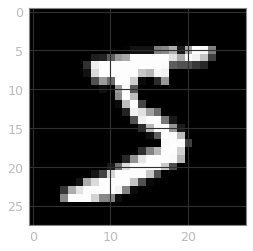

In [23]:
plt.imshow(img.view((28,28)));

## Initial python model

In [25]:
weights = torch.randn(784,10)

In [26]:
bias = torch.zeros(10)

#### Matrix multiplication

In [46]:
def matmul(a,b):
    a_rows,a_cols = a.shape
    b_rows,b_cols = b.shape
    assert a_cols==b_rows
    c = torch.zeros(a_rows, b_cols)
    for i in range(a_rows):
        for j in range(b_cols):
            for k in range(a_cols): # or b_rows
                c[i,j] += a[i,k] * b[k,j]
    return c

In [29]:
m1 = x_valid[:5]
m2 = weights

In [30]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [31]:
%time t1=matmul(m1, m2)

CPU times: user 746 ms, sys: 0 ns, total: 746 ms
Wall time: 745 ms


In [32]:
t1.shape

torch.Size([5, 10])

This is kinda slow - what if we could speed it up by 50,000 times? Let's try!

That's why we don't write things in python! It's way too slow

In [33]:
len(x_train) #imagine running this matmul for all these training examples instead of 5!!

50000

So let's try to write things using PyTorch, which uses the [ATen](https://github.com/zdevito/ATen) library (C++) behind the scenes!

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [34]:
# examles of element-wise operation between torch tensors
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [35]:
a + b

tensor([12., 14.,  3.])

In [ ]:
(a < b).float().mean()

tensor(0.6667)

In [36]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

In [39]:
(m*m).sum().sqrt() # * is elemnt-wise multiplication

tensor(16.8819)

#### Elementwise matmul

We can now substitute the last loop (which is summing over columns of a and rows of b, with an element-wise operation between tensors (' rows/cols)

In [43]:
def matmul_ew(a,b):
    a_rows, a_cols = a.shape
    b_rows, b_cols = b.shape
    assert a_cols == b_rows
    c = torch.zeros(a_rows,b_cols)
    for i in range(a_rows):
        for j in range(b_cols):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c
        

According to the docs any trailing ",:" can be removed, but since we can't do the same for the leading ones (of course) I like to keep my code consistent and explicit

In [51]:
%timeit -n 10 _=matmul(m1, m2)
%timeit -n 10 _=matmul_ew(m1, m2)

703 ms ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
880 µs ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we've just reduced the computational cost by a factor of ~600 to a 1000 depending on the run

In [55]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): 
    """
    test that two matrices are near one another up to a certain tollerance (for floats)
    """
    test(a,b,near)

In [57]:
t1 = matmul(m1,m2)
t2 = matmul_ew(m1,m2)
test_near(t1,t2)

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

See also [here](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html)

In [68]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [71]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [72]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [75]:
t = c.expand_as(m) # too see what broadcast tensor looks like
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [78]:
t.storage() # but the storage is just for each element, they're not copied!

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [81]:
t.stride(), t.shape # the stride tells the interpreter how to move! 
#row to row we're moving ZERO steps through the storage, 
#   so all the element on a colum are equal!
# col to col we're moving one step through the storage

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [69]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [82]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [83]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [84]:
c.shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [86]:
c[None].shape,c[None,:].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [88]:
c[:,None].expand_as(m) # this broadcasted the columns now!

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [89]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [90]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

#### Matmul with broadcasting

In [97]:
m[1,:] 

tensor([4., 5., 6.])

In [99]:
m[1,:].unsqueeze(-1)

tensor([[4.],
        [5.],
        [6.]])

In [98]:
m[1,:][...,None] 

tensor([[4.],
        [5.],
        [6.]])

In [103]:
m[1,:].unsqueeze(-1).expand_as(m)

tensor([[4., 4., 4.],
        [5., 5., 5.],
        [6., 6., 6.]])

In [102]:
m[1,:].expand_as(m)

tensor([[4., 5., 6.],
        [4., 5., 6.],
        [4., 5., 6.]])

In [104]:
def matmul_br(a,b):
    a_rows, a_cols = a.shape
    b_rows, b_cols = b.shape
    assert a_cols == b_rows
    c = torch.zeros(a_rows,b_cols)
    for i in range(a_rows):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous, for j in range(b_cols)
        c[i,:]   = (a[i,:].unsqueeze(-1) * b).sum(dim=0) # dim=0 is similar to axis=0 in np
    return c

In [106]:
%timeit -n 10 _=matmul(m1, m2)
%timeit -n 10 _=matmul_ew(m1, m2)
%timeit -n 10 _=matmul_br(m1, m2)

735 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.02 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
238 µs ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
735000/238

3088.235294117647

\> 3000 times speedup! -- and it works (see below)

In [108]:
test_near(t1, matmul_br(m1, m2))

### Broadcasting rules as a reminder
When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=4280)

In [109]:
# c[i,j] += a[i,k] * b[k,j]
# swap around terms:
# a[i,k] * b[k,j] -> c[i,j] 
# remove mat names (they go as parameters afterwards)
# [i,k] * [k,j] -> [i,j]
# remove brakets and commas, assume you're doing dot products over the same index-letter
# ik,kj -> ij
# so you're creating an output of size ij computing dot products over shared index k
# This is Einstein summation!
def matmul_es(a,b): return torch.einsum('ik,kj->ij', a, b)

In [110]:
%timeit -n 10 _=matmul(m1, m2)
%timeit -n 10 _=matmul_ew(m1, m2)
%timeit -n 10 _=matmul_br(m1, m2)
%timeit -n 10 _=matmul_es(m1, m2)

737 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
902 µs ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
219 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.7 µs ± 8.23 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [111]:
737000/31

23774.1935483871

\> 20000 times speedup. Now we're really at C speed for the whole matmul!

In [113]:
test_near(t1, matmul_es(m1, m2)) # check that it's correct

In [ ]:
# This is nice because, for example, think if pytorch didn't support batc-wise matmul...
def bw_matmul(a,b): return torch.einsum('bik,kj->bij', a, b)
# created!
# So there's a lot we can do with this notation!

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [116]:
%timeit -n 10 _=matmul(m1, m2)
%timeit -n 10 _=matmul_ew(m1, m2)
%timeit -n 10 _=matmul_br(m1, m2)
%timeit -n 10 _=matmul_es(m1, m2)
%timeit -n 10 t2 = m1.matmul(m2)
%timeit -n 10 t2 = m1@m2

727 ms ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.04 ms ± 75.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
246 µs ± 33.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37 µs ± 8.88 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.73 µs ± 6.04 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.82 µs ± 6.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
# time comparison vs pure python:
727000/6

121166.66666666667

So using pytorch is still the best we can do! Because pytorch delegate to a BLAS library that is optimized for each architectures

In [118]:
t2 = m1@m2 # @ covers a lot of tensor reductions (like batchwise, etc...) actually!

In [119]:
test_near(t1, t2)

In [120]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

## Export

In [122]:
!python3 notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py


This exports basically the test